# Automatic Differentiation
:label:`sec_autograd`

As we have explained in :numref:`sec_calculus`,
differentiation is a crucial step in nearly all deep learning optimization algorithms.
While the calculations for taking these derivatives are straightforward,
requiring only some basic calculus,
for complex models, working out the updates by hand
can be a pain (and often error-prone).

Deep learning frameworks expedite this work
by automatically calculating derivatives, i.e., *automatic differentiation*.
In practice,
based on our designed model
the system builds a *computational graph*,
tracking which data combined through
which operations to produce the output.
Automatic differentiation enables the system to subsequently backpropagate gradients.
Here, *backpropagate* simply means to trace through the computational graph,
filling in the partial derivatives with respect to each parameter.


## A Simple Example

As a toy example, say that we are interested
in (**differentiating the function
$y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to the column vector $\mathbf{x}$.**)
To start, let us create the variable `x` and assign it an initial value.


In [68]:
import tensorflow as tf
import d2l

x = tf.range(4, dtype=tf.float32)
x

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 1., 2., 3.], dtype=float32)>

[**Before we even calculate the gradient
of $y$ with respect to $\mathbf{x}$,
we will need a place to store it.**]
It is important that we do not allocate new memory
every time we take a derivative with respect to a parameter
because we will often update the same parameters
thousands or millions of times
and could quickly run out of memory.
Note that a gradient of a scalar-valued function
with respect to a vector $\mathbf{x}$
is itself vector-valued and has the same shape as $\mathbf{x}$.


In [69]:
x = tf.Variable(x)

(**Now let us calculate $y$.**)


In [70]:
# Record all computations onto a tape
with tf.GradientTape() as t:
    y = 2 * tf.tensordot(x, x, axes=1) # y = 2((x_0)^2 + ... (x_3)^2)
y

<tf.Tensor: shape=(), dtype=float32, numpy=28.0>

Since `x` is a vector of length 4,
an dot product of `x` and `x` is performed,
yielding the scalar output that we assign to `y`.
Next, [**we can automatically calculate the gradient of `y`
with respect to each component of `x`**]
by calling the function for backpropagation and printing the gradient.


In [71]:
x_grad = t.gradient(y, x) # dy/dx_i = 4x_i, i -> [0, 1, 2, 3] 
x_grad

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.,  4.,  8., 12.], dtype=float32)>

(**The gradient of the function $y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to $\mathbf{x}$ should be $4\mathbf{x}$.**)
Let us quickly verify that our desired gradient was calculated correctly.


In [72]:
x_grad == 4 * x

<tf.Tensor: shape=(4,), dtype=bool, numpy=array([ True,  True,  True,  True])>

[**Now let us calculate another function of `x`.**]


In [73]:
with tf.GradientTape() as t:
    y = tf.reduce_sum(x) # y = x_1 + x_2 + x_3 + x_4
t.gradient(y, x)  # Overwritten by the newly calculated gradient

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>

**Let us try y = x^3**

$\frac{dy}{dx} = 3x^2$

In [74]:
with tf.GradientTape() as t:
    y = tf.reduce_sum(x * x * x)
print(t.gradient(y, x))

with tf.GradientTape() as t:
    y = x * x * x
t.gradient(y, x)

tf.Tensor([ 0.  3. 12. 27.], shape=(4,), dtype=float32)


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.,  3., 12., 27.], dtype=float32)>

## Backward for Non-Scalar Variables

Technically, when `y` is not a scalar,
the most natural interpretation of the differentiation of a vector `y`
with respect to a vector `x` is a matrix.
For higher-order and higher-dimensional `y` and `x`,
the differentiation result could be a high-order tensor.

However, while these more exotic objects do show up
in advanced machine learning (including [**in deep learning**]),
more often (**when we are calling backward on a vector,**)
we are trying to calculate the derivatives of the loss functions
for each constituent of a *batch* of training examples.
Here, (**our intent is**) not to calculate the differentiation matrix
but rather (**the sum of the partial derivatives
computed individually for each example**) in the batch.


In [58]:
with tf.GradientTape() as t:
    y = x * x
t.gradient(y, x)  # Same as `y = tf.reduce_sum(x * x)`

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 2., 4., 6.], dtype=float32)>

## Detaching Computation

Sometimes, we wish to [**move some calculations
outside of the recorded computational graph.**]
For example, say that `y` was calculated as a function of `x`,
and that subsequently `z` was calculated as a function of both `y` and `x`.
Now, imagine that we wanted to calculate
the gradient of `z` with respect to `x`,
but wanted for some reason to treat `y` as a constant,
and only take into account the role
that `x` played after `y` was calculated.

Here, we can detach `y` to return a new variable `u`
that has the same value as `y` but discards any information
about how `y` was computed in the computational graph.
In other words, the gradient will not flow backwards through `u` to `x`.
Thus, the following backpropagation function computes
the partial derivative of `z = u * x` with respect to `x` while treating `u` as a constant,
instead of the partial derivative of `z = x * x * x` with respect to `x`.


In [59]:
# Set `persistent=True` to run `t.gradient` more than once
with tf.GradientTape(persistent=True) as t:
    y = x * x
    u = tf.stop_gradient(y) # treats y as a constant
#     u = y
    z = u * x # z = xy, so z_x (or partial of z wrt x) = y, where y = x^2, and z is not equal to x^3

x_grad = t.gradient(z, x)
# x_grad == u
x_grad

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 1., 4., 9.], dtype=float32)>

Since the computation of `y` was recorded,
we can subsequently invoke backpropagation on `y` to get the derivative of `y = x * x` with respect to `x`, which is `2 * x`.


In [60]:
t.gradient(y, x) == 2 * x

<tf.Tensor: shape=(4,), dtype=bool, numpy=array([ True,  True,  True,  True])>

## Computing the Gradient of Python Control Flow

One benefit of using automatic differentiation
is that [**even if**] building the computational graph of (**a function
required passing through a maze of Python control flow**)
(e.g., conditionals, loops, and arbitrary function calls),
(**we can still calculate the gradient of the resulting variable.**)
In the following snippet, note that
the number of iterations of the `while` loop
and the evaluation of the `if` statement
both depend on the value of the input `a`.


In [61]:
def f(a):
    b = a * 2
    while tf.norm(b) < 1000:
        b = b * 2
    if tf.reduce_sum(b) > 0:
        c = b
    else:
        c = 100 * b
    return c

Let us compute the gradient.


In [62]:
a = tf.Variable(tf.random.normal(shape=()))
with tf.GradientTape() as t:
    d = f(a)
d_grad = t.gradient(d, a)
d_grad

<tf.Tensor: shape=(), dtype=float32, numpy=102400.0>

We can now analyze the `f` function defined above.
Note that it is piecewise linear in its input `a`.
In other words, for any `a` there exists some constant scalar `k`
such that `f(a) = k * a`, where the value of `k` depends on the input `a`.
Consequently `d / a` allows us to verify that the gradient is correct.


In [63]:
d_grad == d / a

<tf.Tensor: shape=(), dtype=bool, numpy=True>

## Summary

* Deep learning frameworks can automate the calculation of derivatives. To use it, we first attach gradients to those variables with respect to which we desire partial derivatives. We then record the computation of our target value, execute its function for backpropagation, and access the resulting gradient.


## Exercises

1. Why is the second derivative much more expensive to compute than the first derivative? 

I suppose it's because the second derivative requires two calculations, one for taking the derivative of the original function, and then taking the derivative of that.

2. After running the function for backpropagation, immediately run it again and see what happens. 

There is an error, since the gradient tipe is not persistent.


3. In the control flow example where we calculate the derivative of `d` with respect to `a`, what would happen if we changed the variable `a` to a random vector or matrix. At this point, the result of the calculation `f(a)` is no longer a scalar. What happens to the result? How do we analyze this?
4. Redesign an example of finding the gradient of the control flow. Run and analyze the result.
5. Let $f(x) = \sin(x)$. Plot $f(x)$ and $\frac{df(x)}{dx}$, where the latter is computed without exploiting that $f'(x) = \cos(x)$.


In [64]:
# for number 3
a = tf.Variable(tf.random.normal(shape=(3,3), mean = 5, stddev=125))
with tf.GradientTape() as t:
    d = f(a)
d_grad = t.gradient(d, a)
d_grad

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.]], dtype=float32)>

In [65]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

(50,)


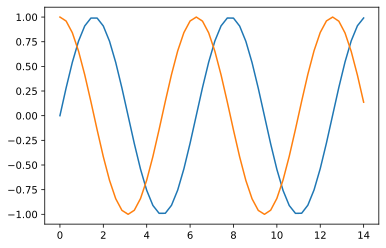

In [75]:
# for number 5
import matplotlib.pyplot as plt

def f(x):
    return tf.math.sin(x)

x = tf.Variable(tf.linspace(0, 14, 50))

print(x.shape)
with tf.GradientTape() as t:
    y = f(x)
f_grad = t.gradient(y, x)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(x.numpy(), y.numpy())
plt.plot(x.numpy(), f_grad.numpy())

[Discussions](https://discuss.d2l.ai/t/200)
